In [1]:
from langchain_core.tools import tool
import httpx
from geopy.geocoders import Nominatim
import json

def get_coordinates(city_name: str) -> tuple[float, float]:
    """도시 이름을 받아 위도와 경도를 반환합니다."""
    geolocator = Nominatim(user_agent="weather_app_langgraph")
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    raise ValueError(f"좌표를 찾을 수 없습니다: {city_name}")

@tool
def get_weather(city_name: str) -> str:
    """도시 이름을 받아 해당 도시의 현재 날씨 정보를 반환합니다."""
    print(f"날씨 조회: {city_name}")
    latitude, longitude = get_coordinates(city_name)
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    response = httpx.get(url)
    response.raise_for_status()
    return json.dumps(response.json())

tools = [get_weather]

In [2]:
from langgraph.prebuilt import ToolNode # 에이전트와 도구 간의 인터페이스 역할을 하며, 언어 모델의 지시에 따라 실제 도구 실행을 담당하는 핵심적인 중간 다리
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

from dotenv import load_dotenv
load_dotenv()

# * 기상 전문가 서브 그래프 생성
def create_weather_agent():
    """날씨 관련 질문을 처리하는 전문가 서브그래프를 생성합니다."""
    model = ChatGoogleGenerativeAI(model="gemini-2.5-flash").bind_tools(tools)
    tool_node = ToolNode([get_weather])

    def call_model(state: MessagesState):
        return {"messages": [model.invoke(state["messages"])]}

    graph_builder = StateGraph(MessagesState)
    graph_builder.add_node("call_model", call_model)
    graph_builder.add_node("tool_node", tool_node)

    graph_builder.add_edge(START, "call_model")
    graph_builder.add_conditional_edges(
        "call_model",
        lambda s: "tool_node" if s["messages"][-1].tool_calls else END,
        {"tool_node": "tool_node", END: END},
    )
    graph_builder.add_edge("tool_node", "call_model")
    return graph_builder.compile()

In [3]:
from typing import Literal

# * 라우터 생성
def router(state: MessagesState) -> Literal["weather_expert", "general_agent"]:
    query = state["messages"][-1].content.lower()
    if "날씨" in query or "기온" in query:
        print("라우팅 결정: 기상 전문가에게 위임")
        return "weather_expert"
    print("라우팅 결정: 일반 에이전트가 처리")
    return "general_agent"

In [4]:
# * 메인 그래프 생성
def create_main_agent(weather_subgraph):
    """질문을 라우팅하고 처리하는 메인 에이전트 그래프를 생성합니다."""
    main_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash") # 모델을 다르게 사용 가능

    graph_builder = StateGraph(MessagesState)
    graph_builder.add_node(
        "general_agent", lambda s: {"messages": [main_model.invoke(s["messages"])]}
    )
    graph_builder.add_node("weather_expert", weather_subgraph)
    graph_builder.add_conditional_edges(
        START,
        router,
        {
            "weather_expert": "weather_expert",
            "general_agent": "general_agent",
        },
    )
    graph_builder.add_edge("general_agent", END)
    graph_builder.add_edge("weather_expert", END)
    return graph_builder.compile()

=== LangGraph 서브그래프 예제 (기상 전문가) ===



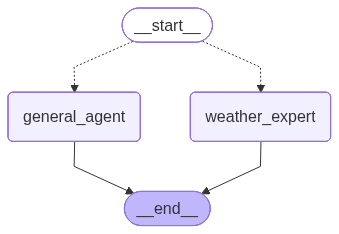

In [5]:
from IPython.display import Image, display

print("=== LangGraph 서브그래프 예제 (기상 전문가) ===\n")
weather_agent = create_weather_agent()
main_agent = create_main_agent(weather_agent)

try:
    display(Image(main_agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
try:
    display(Image(main_agent.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [9]:
from langchain_core.messages import HumanMessage

query = "부산 날씨 어때?"
result = main_agent.invoke({"messages": [HumanMessage(content=query)]})

result

라우팅 결정: 기상 전문가에게 위임
날씨 조회: 부산


{'messages': [HumanMessage(content='부산 날씨 어때?', additional_kwargs={}, response_metadata={}, id='163ff237-319f-4663-9741-e01bfe92335c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city_name": "\\ubd80\\uc0b0"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7c75be04-3794-4708-9f7b-98b060d1d130-0', tool_calls=[{'name': 'get_weather', 'args': {'city_name': '부산'}, 'id': 'f7c01804-04fb-4712-bf3d-f5ee4cd561cb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 81, 'total_tokens': 138, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 64}}),
  ToolMessage(content='{"latitude": 35.2, "longitude": 129.0625, "generationtime_ms": 0.04661083221435547, "utc_offset_seconds": 0, "timezone": "GMT", "timezone_abbreviation": "GMT", "elevation": 26.0, "current_weather

In [10]:
from langchain_core.messages import HumanMessage

query = "랭그래프에 대해 핵심만 간단히 설명해줘."
result = main_agent.invoke({"messages": [HumanMessage(content=query)]})

result

라우팅 결정: 일반 에이전트가 처리


{'messages': [HumanMessage(content='랭그래프에 대해 핵심만 간단히 설명해줘.', additional_kwargs={}, response_metadata={}, id='ae34f21e-1b4d-4a4b-9663-714750f0ece4'),
  AIMessage(content="랭그래프(LangGraph)는 랭체인(LangChain)의 한 부분으로, **복잡한 LLM 애플리케이션(특히 '에이전트')의 실행 흐름을 '그래프' 형태로 설계하고 제어하는 도구**입니다.\n\n핵심 특징은 다음과 같습니다:\n\n1.  **그래프 구조:** 각 단계를 '노드(Node)'로, 단계 간의 흐름을 '엣지(Edge)'로 정의하여 시각적이고 명확하게 로직을 구성합니다.\n2.  **상태 관리:** LLM이 여러 단계를 거치면서 정보를 기억하고 전달할 수 있도록 '상태(State)'를 자동으로 관리해줍니다.\n3.  **순환(Cycle) 허용:** 가장 중요한 특징으로, 일반적인 파이프라인과 달리 특정 조건이 충족될 때까지 '생각하고, 도구를 사용하고, 다시 생각하는' 등의 반복적인 행동(루프)을 구현할 수 있습니다. 이는 복잡한 에이전트 로직에 필수적입니다.\n\n쉽게 말해, LLM이 여러 단계에 걸쳐 복잡한 작업을 수행할 때, 그 과정(흐름)을 명확하게 설계하고 제어하며, 중간 상태를 기억하고 반복적인 행동을 가능하게 하는 **'프로세스 설계 및 실행 도구'**라고 생각하시면 됩니다.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--3221560e-3117-4033-ab90-005ecc5ce96f-0', usage_metadata={'input_token